## Problem context

An English document has been corrupted in an unusual manner. Each alphabetic word (no numbers, but apostrophes allowed) has had every other character replaced with a `#` character. For example, a sentence like
```
I'm here. It's a cat.
```
would appear in the document as
```
I#m h#r#. I#'# a c#t.
```

We have extracted the tokens from this corrupted document and have provided the list of tokens to you as `corrupted_tokens.txt`. Note that the order of tokens in the list is the same as how they appeared in the original document, and that surrounding punctuation like `.` and `,` have been removed.

As an example, if the uncorrupted document is:
```
I'm here. It's a cat.
```
the its corresponding corruption followed by tokenization would be:
```
I#m
h#r#
I#'#
a
c#t
```

In [725]:
import pandas as pd
import numpy as np
import plotly.express as px
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
from spellchecker import SpellChecker
from textblob import TextBlob

In [2]:
# read in corrupted tokens
#changed example to make all text lower case

CORRUPTED_TOKENS = []

with open('corrupted_tokens.txt', 'r', encoding='utf-8') as f:
    for line in f:
        tok = line.strip()
        CORRUPTED_TOKENS.append(tok.lower())
        
TRAINING_TOKENS = []
with open('training_tokens.txt', 'r', encoding='utf-8') as f:
    for line in f:
        tok = line.strip()
        TRAINING_TOKENS.append(tok.lower())

# New Section

## Task

Try to recover the corrupted tokens as best you can and write your guess of the original tokens to a file `recovered_tokens.txt`, one token per line. Each line in `recovered_tokens.txt` should match its corresponding line in `corrupted_tokens.txt`.

To enable you to do this, you are given a tokenization of an uncorrupted training document, i.e. the `training_tokens.txt` file. This file also one token per line and its tokens appear in the same order as in the uncorrupted training document. You can use this along with whatever external material you deem necessary to inform your recovery of the corrupted tokens.

You may use whatever language and/or tools you deem necessary.

Please submit your solution consisting of:
1. your `recovered_tokens.txt` file. This should contain the same number of tokens/lines as `corrupted_tokens.txt`. Additionally, case is not important for the recovered tokens, i.e. we treat `Prince` the same as `prince` the same as `PRINCE` .
2. your code for your attempt in recovering the corrupted tokens
3. a short write-up of your methodology

## Carlos Bonilla solution

In [721]:
#Create a datas attribute with the available data
def featureEngineering(df):
    df['corruptedTokenLength']=df['corruptedToken'].astype(str).apply(len)
    df['corruptedTokenFirstLetter'] = df['corruptedToken'].astype(str).str[0]
    df['nextCorruptedToken'] = df['corruptedToken'].shift(-1)
    df['nextCorruptedToken2'] = df['corruptedToken'].shift(-2)
    df['nextCorruptedToken3'] = df['corruptedToken'].shift(-3)
    df['previousCorruptedToken'] = df['corruptedToken'].shift(1)
    df['previousCorruptedToken2'] = df['corruptedToken'].shift(2)
    df['previousCorruptedToken3'] = df['corruptedToken'].shift(3)
    df['nextLength'] = df['nextCorruptedToken'].astype(str).apply(len)
    df['next2Length'] = df['nextCorruptedToken2'].astype(str).apply(len)
    df['next3Length'] = df['nextCorruptedToken3'].astype(str).apply(len)
    df['previousLength'] = df['previousCorruptedToken'].astype(str).apply(len)
    df['previous2Length'] = df['previousCorruptedToken2'].astype(str).apply(len)
    df['previous3Length'] = df['previousCorruptedToken3'].astype(str).apply(len)
    df['nextFirstLetter'] = df['nextCorruptedToken'].astype(str).str[0]
    df['nextFirstLetter2'] = df['nextCorruptedToken2'].astype(str).str[0]
    df['nextFirstLetter3'] = df['nextCorruptedToken3'].astype(str).str[0]
    df['previousFirstLetter'] = df['previousCorruptedToken'].astype(str).str[0]
    df['previousFirstLetter2'] = df['previousCorruptedToken2'].astype(str).str[0]
    df['previousFirstLetter3'] = df['previousCorruptedToken3'].astype(str).str[0]
    return df

def dummy_predictor(corrupted_token):
    return corrupted_token.lower().replace('#', 'e')

In [332]:
#Convert CORRUPTED_TOKENS list to dataframe for easier manipulation
corrupted_df = pd.DataFrame(CORRUPTED_TOKENS,columns =['corruptedToken'])

#Create a data attributes with the corrupted tokens
corrupted_df = featureEngineering(corrupted_df)

#Vissualy inspect the new Length attribute
#corrupted_df.groupby(['length']).size()

#Observations to note
##The longest token is 17 strings long
##The one length tokens have no corruption 

##We can 'cheat' with this loop because we know that every other letter is
##corrupted and the length of the longest token but a more general model
##would require different logic
for y in (0,2,4,6,8,10,12,14,16):
  name = str('letterPosition_'+str(y))
  corrupted_df[name] = corrupted_df['corruptedToken'].astype(str).str[y]

In [334]:
#create a dataframe of all unique groups of first letter corrupted tokens and corruptedTokenLength
corruptedTokenList = corrupted_df[['corruptedTokenLength','letterPosition_0',]].drop_duplicates()

#Visually inspect the corruptedToken attribute
#corrupted_Summary = corrupted_df[['corruptedToken','corruptedTokenLength']].groupby(['corruptedToken']).count().reset_index()[['corruptedToken','corruptedTokenLength']].sort_values('corruptedTokenLength',ascending=False)
#fig = px.bar(corrupted_Summary[0:40], x='corruptedToken', y='length')
#fig.show()

#Observations to note
##The most common words are probably filler words like the, it and and
##With that said there could be instances of tea, in and add so will need
##to find a way to consider those cases
##For corrupted tokens with only one observation it might make sense to make
##a brute search in the training dataset

In [335]:
#Let's replicate creating features for the TRAINING_TOKENS data like we did for 
#the CORRUPTED_TOKENS for training purposes
training_df = pd.DataFrame(TRAINING_TOKENS,columns =['trainingToken'])
training_df['trainingToken'] = training_df['trainingToken'].astype('category')

#Create a corrupted token
def Convert(string):
    list1=[]
    list1[:0]=string

    for i in range(0,len(list1)):
      if (i % 2) != 0:
        list1[i]='#'
    return ''.join(str(i) for i in list1)

test = []
for y in range(0,len(TRAINING_TOKENS)):
    corruption = Convert(TRAINING_TOKENS[y])
    test.append(corruption)
    
training_df['corruptedToken'] = test
training_df['corruptedToken'] = training_df['corruptedToken'].astype('category')

#Create a data attributes with the available data
training_df = featureEngineering(training_df)

#Let's remove all single length tokens since we won't be using them
training_df = training_df.loc[training_df['corruptedTokenLength'] > 1] 
#Let's also remove all tokens of length longer than 17 since they don't exist in 
#the corrupted dataset
training_df = training_df.loc[training_df['corruptedTokenLength'] < 18]

#create a corrupted version of the training set
#training_df['sampleCorruptedToken'] = training_df['trainingToken']

In [337]:
#Function to letter position variables for training every unique combination in corruptedTokenList
def trainingSets(df,corruptedTokenLength,corruptedTokenFirstLetter):
    temp = df.loc[df['corruptedTokenLength'] == corruptedTokenLength].loc[df['corruptedTokenFirstLetter'] == corruptedTokenFirstLetter]
    for y in np.arange(0,corruptedTokenLength,2):
        name = str('letterPosition_'+str(y))
        temp[name] = temp['corruptedToken'].astype(str).str[y]
    temp = temp.drop(columns=['nextCorruptedToken','nextCorruptedToken2','nextCorruptedToken3','previousCorruptedToken',
                              'previousCorruptedToken2','previousCorruptedToken3'])
    return temp.replace(["'",'a', 'b', 'c', 'd','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z'], [27,1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26])

In [342]:
#Loop to create a list of dataframes, maintaining the same order as the corruptedTokenList
traingSetDataframes = []
for i in range(0,len(corruptedTokenList)):
    setDf = trainingSets(df=training_df,corruptedTokenLength=corruptedTokenList.iloc[i,[0,1]][0],corruptedTokenFirstLetter=corruptedTokenList.iloc[i,[0,1]][1])
    traingSetDataframes.append(setDf)

In [377]:
#function to fit a scikit learn SVM given a dataframe created from trainingSets 
def runSVM(df):
    X_train = df.drop_duplicates().drop(columns=['trainingToken','corruptedToken','corruptedTokenFirstLetter'])
    y_train = df.drop_duplicates()[['trainingToken']]
    clf = svm.SVC(gamma=0.001)
    return (clf.fit(X_train, y_train.values.ravel()),X_train,y_train)

In [378]:
traingModels = []

for i in range(0,303):
    try:
        x = runSVM(traingSetDataframes[i])
        traingModels.append(x)
    except ValueError:
        x = 'TRAINING FAILED'
        traingModels.append(x)

In [757]:
filename = 'finalized_model.sav'
pickle.dump(traingModels, open(filename, 'wb'))

In [367]:
#loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
df_TEMP = traingSetDataframes[0][['corruptedTokenLength','letterPosition_0']].drop_duplicates().values.tolist()[0]
d = {'ModelNumber': [0], 'corruptedTokenLength': [df_TEMP[0]],'letterPosition_0': [df_TEMP[1]]}
trainingModelIndex = pd.DataFrame(data=d)

for i in range(1,303):
    try:
        df = traingSetDataframes[i][['corruptedTokenLength','letterPosition_0']].drop_duplicates().values.tolist()[0]
        d = {'ModelNumber': [i], 'corruptedTokenLength': [df[0]],'letterPosition_0': [df[1]]}
        df = pd.DataFrame(data=d)
    except IndexError:
        d = {'ModelNumber': [i], 'corruptedTokenLength': [0],'letterPosition_0': [0]}
        df = pd.DataFrame(data=d)
    trainingModelIndex = trainingModelIndex.append(pd.DataFrame(data=d))

In [767]:
#Function to create dataframes for predicting the corruptedTokens
def predictFormat(corruptedTokenDf,position):
    df = corruptedTokenDf.iloc[position,].drop(labels=['corruptedTokenFirstLetter','nextCorruptedToken','nextCorruptedToken2','nextCorruptedToken3','previousCorruptedToken',
                              'previousCorruptedToken2','previousCorruptedToken3'])
    
    toDrop = []   
    for y in np.arange(round(df['corruptedTokenLength']/2.)*2,18,2):
        name = str('letterPosition_'+str(y))
        toDrop.append(name)
    
    df = df.drop(labels=toDrop)
    
    return df


In [774]:
def findModel(corruptedFormatted):
    letterPosition_0 = corruptedFormatted['letterPosition_0']
    corruptedTokenLength = corruptedFormatted['corruptedTokenLength']
    corruptedFormatted = corruptedFormatted.replace(["'",'a', 'b', 'c', 'd','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z'], [27,1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26])
    index = trainingModelIndex.loc[(trainingModelIndex['letterPosition_0']==corruptedFormatted['letterPosition_0']) & (trainingModelIndex['corruptedTokenLength']==corruptedFormatted['corruptedTokenLength'])]
    model = traingModels[index['ModelNumber'][0]]
    return model

In [787]:
#predict a Token given the ouput of predictFormat(corruptedTokenDf,position)
def predictToken(corruptedFormatted):
    try:
        letterPosition_0 = corruptedFormatted['letterPosition_0']
        corruptedTokenLength = corruptedFormatted['corruptedTokenLength']
        corruptedFormatted = corruptedFormatted.replace(["'",'a', 'b', 'c', 'd','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z'], [27,1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26])
        index = trainingModelIndex.loc[(trainingModelIndex['letterPosition_0']==corruptedFormatted['letterPosition_0']) & (trainingModelIndex['corruptedTokenLength']==corruptedFormatted['corruptedTokenLength'])]
        model = traingModels[index['ModelNumber'][0]][0]
        corruptedFormatted_NEW = corruptedFormatted.drop(labels=['corruptedToken'])
        predicted = model.predict(corruptedFormatted_NEW.values.reshape(1, -1))[0]
    except:
        predicted = corruptedFormatted['corruptedToken']
    return predicted

In [800]:
#outputTokensNEW = []
for i in range(0,29293):
    predictionAttempt = predictToken(predictFormat(corruptedTokenDf=corrupted_df,position=i))
    outputTokensNEW.append(predictionAttempt)

IndexError: single positional indexer is out-of-bounds

In [755]:
Predictionsfilename = 'finalizedPredictions.sav'
pickle.dump(outputTokens, open(Predictionsfilename, 'wb'))

In [756]:
loadedPredictions = pickle.load(open(filename, 'rb'))

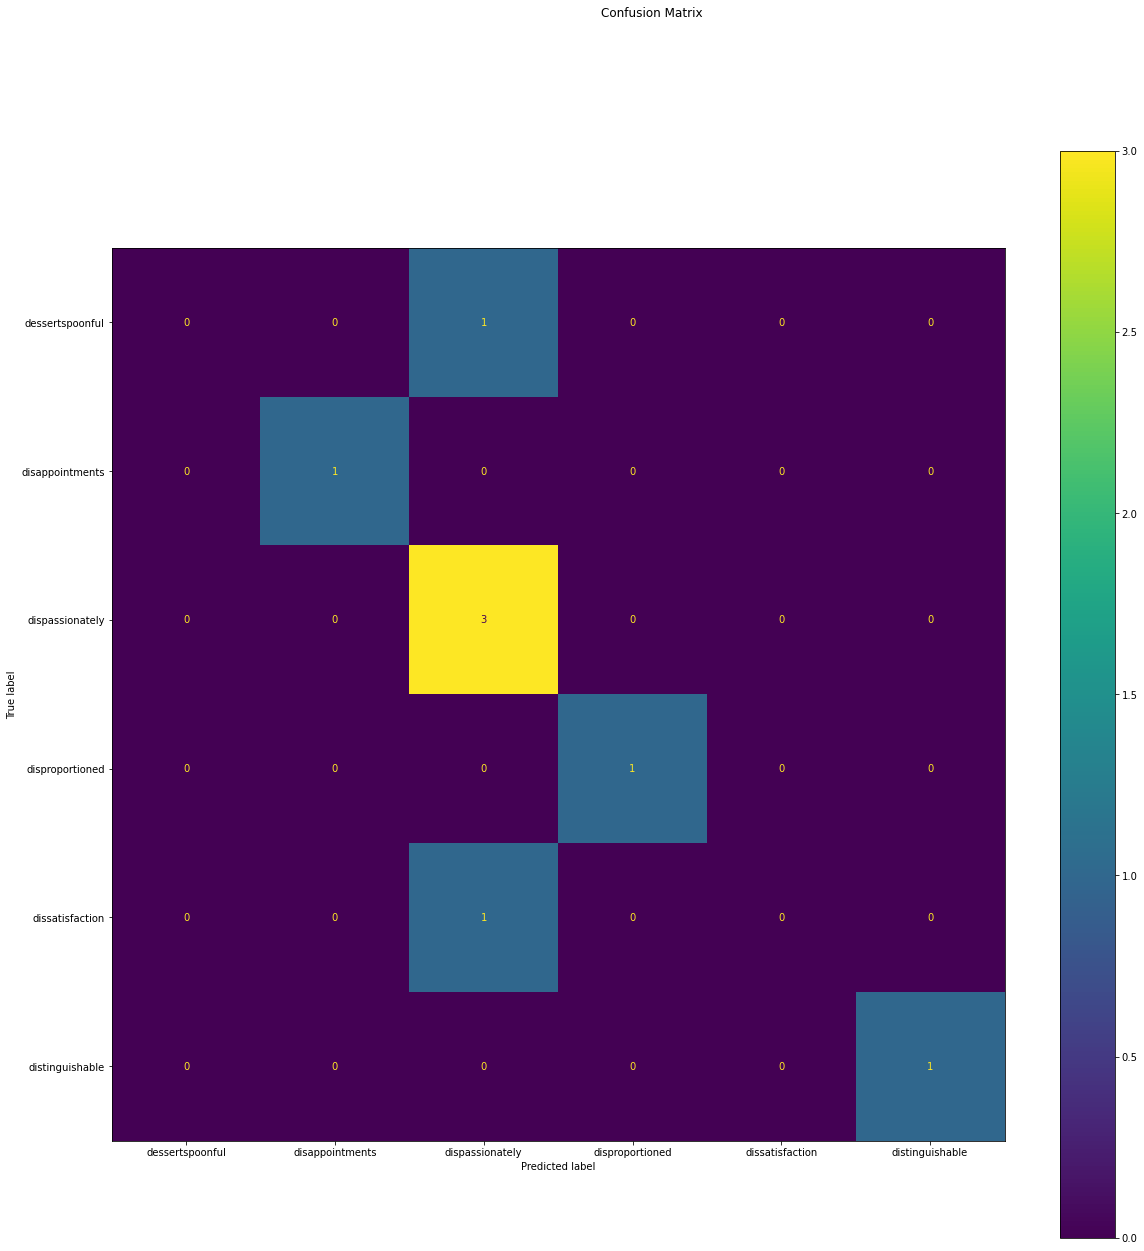

In [32]:
fig, ax = plt.subplots(figsize=(20, 20))
disp = metrics.plot_confusion_matrix(runSVM(traingSetDataframes[286])[0], runSVM(traingSetDataframes[286])[1], runSVM(traingSetDataframes[286])[2],ax=ax)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

In [ ]:
MyFile=open('outputCarlos.txt','w')

for element in outputTokensNEW:
     MyFile.write(element)
     MyFile.write('\n')
MyFile.close()